# Bootstrap templates

## Table of Contents
* [Poisson bootstrap for TP, TN, FP, FN template](#1)
* [Bootstrap with p value template](#2)
* [Poisson Bootstrap with p value template](#3)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from typing import Callable

## Poisson bootstrap for TP, TN, FP, FN template <a class="anchor" id="1"></a>

In [3]:
N = 100000
B = 1000
labels = np.random.randint(0, 2, N)  # real labels with two classes 0 and 1
predicts = np.random.normal(0.5, 1, N)  # predicted scores from 0 to 1
predicts = np.clip(predicts, 0, 1)
weights = np.ones(N)  # could be different weights for samples, here all the same

In [4]:
data = list(zip(labels, predicts, weights))

In [11]:
def poisson_bootstrap(
    data: list[tuple[float, float, float]], 
    B: int, 
    threshold: float  # we can pick up most suitable threshold for predictions
) -> List[np.array]:
    
    TP = np.zeros(B)
    FP = np.zeros(B)
    FN = np.zeros(B)
    TN = np.zeros(B)
    
    for label, predict, weight in data:
        predict += np.random.normal(0, 0.05, 1)
        predict = np.clip(predict, 0, 1)
        predict = int(predict >= threshold)
        poisson = np.random.poisson(lam=1, size=B) * weight
        
        if label == 1 and predict == 1:
            TP += poisson
        if label == 0 and predict == 0:
            TN += poisson
        if label == 0 and predict == 1:
            FP += poisson
        if label == 1 and predict == 0:
            FN += poisson
            
    return TP, FP, FN, TN
            

In [12]:
res = poisson_bootstrap(data, B, 0.5)
np.sum(res, axis=1)

array([24942699., 25034227., 25123276., 24911285.])

In [7]:
res = poisson_bootstrap(data, B, 0.7)
np.sum(res, axis=1)

array([21094543., 20999662., 28971069., 28943544.])

In [8]:
res = poisson_bootstrap(data, B, 0.9)
np.sum(res, axis=1)

array([16919258., 16805860., 33142835., 33127677.])

## Bootstrap with p value template <a class="anchor" id="2"></a>

In [118]:
def get_bootstrap(
    group_1: np.ndarray,
    group_2: np.ndarray,
    B: int = 1000, 
    stat: Callable = np.mean,
    bootstrap_conf_level: float = 0.95,
    vis: bool = False
) -> dict:
    
    N = max(len(data_column_1), len(data_column_2))
    boot_data = []
    
    for _ in range(B): 
        samples_1 = np.random.choice(group_1, N)
        samples_2 = np.random.choice(group_2, N)
        diff = stat(samples_1) - stat(samples_2)
        boot_data.append(diff)
        
    boot_frame = pd.DataFrame(boot_data)
    
    # p-value calculation
    p_1 = scipy.stats.norm.cdf(x = 0, loc = np.mean(boot_data), scale = np.std(boot_data))
    p_2 = scipy.stats.norm.cdf(x = 0, loc = -np.mean(boot_data), scale = np.std(boot_data))
    p_value = min(p_1, p_2) * 2
    
    # qiantiles can be used to check if 0 in incide conf interval 
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - ((1 - bootstrap_conf_level) / 2)
    quants = boot_frame.quantile([left_quant, right_quant])
        
    # visualization
    if vis:
        _, ax = plt.subplots(figsize=(8, 3))
        _, _, bars = plt.hist(boot_frame[0], bins = 50)
        for bar in bars:
            if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
                bar.set_facecolor('red')
            else: 
                bar.set_facecolor('grey')
                bar.set_edgecolor('black')

        plt.vlines(quants, ymin=0, ymax=50, linestyle='--')
        plt.xlabel('boot_data')
        plt.ylabel('frequency')
        plt.title("Histogram of boot_data")
        plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

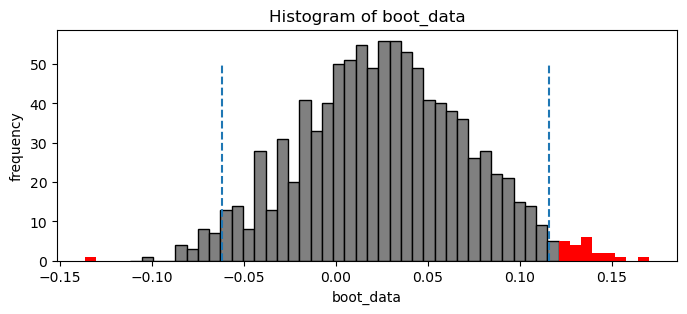

0.5623642611094166

In [119]:
N = 1000
sample_1 = np.random.normal(0.5, 1, N)
sample_2 = np.random.normal(0.5, 1, N)

res = get_bootstrap(sample_1, sample_2, B = 1000, vis=True)
res["p_value"]

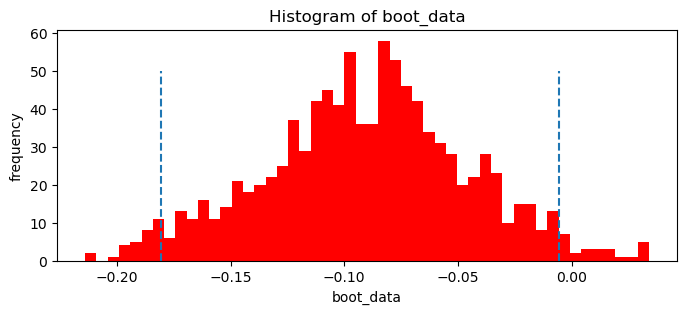

0.04276808180104267

In [123]:
N = 1000
sample_1 = np.random.normal(0.5, 1, N)
sample_2 = np.random.normal(0.5, 1, N) + 0.1

res = get_bootstrap(sample_1, sample_2, B = 1000, vis=True)
res["p_value"]

## Poisson Bootstrap with p value template <a class="anchor" id="3"></a>

In [166]:
def get_poisson_bootstrap(
    group_1: np.ndarray,
    group_2: np.ndarray,
    B: int = 10000,
    bootstrap_conf_level: float = 0.95,
    vis: bool = False
) -> dict:
    
    A_group = np.zeros(B)
    B_group = np.zeros(B)
    # separate loop for case where lengths are different
    for i in range(len(data_column_1)):
        poisson_weights = np.random.poisson(lam=1, size=B)
        A_group += poisson_weights * group_1[i]
        
    for i in range(len(data_column_2)):
        poisson_weights = np.random.poisson(lam=1, size=B)
        B_group += poisson_weights * group_2[i]

    A_group /= N
    B_group /= N

    boot_data = A_group - B_group
        
    boot_frame = pd.DataFrame(boot_data)
    
    # p-value calculation
    p_1 = scipy.stats.norm.cdf(x = 0, loc = np.mean(boot_data), scale = np.std(boot_data))
    p_2 = scipy.stats.norm.cdf(x = 0, loc = -np.mean(boot_data), scale = np.std(boot_data))
    p_value = min(p_1, p_2) * 2
    
    # qiantiles can be used to check if 0 in incide conf interval 
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - ((1 - bootstrap_conf_level) / 2)
    quants = boot_frame.quantile([left_quant, right_quant])
        
    # visualization
    if vis:
        _, ax = plt.subplots(figsize=(8, 3))
        _, _, bars = plt.hist(boot_frame[0], bins = 50)
        for bar in bars:
            if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
                bar.set_facecolor('red')
            else: 
                bar.set_facecolor('grey')
                bar.set_edgecolor('black')

        plt.vlines(quants, ymin=0, ymax=np.sum(np.abs(boot_frame[0])), linestyle='--')
        plt.xlabel('boot_data')
        plt.ylabel('frequency')
        plt.title("Histogram of boot_data")
        plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

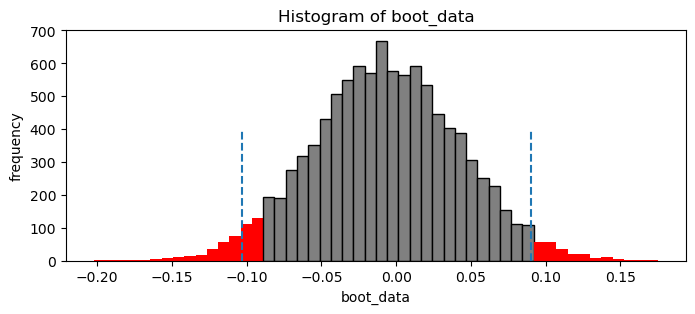

0.888879150351448

In [167]:
N = 1000
sample_1 = np.random.normal(0.5, 1, N)
sample_2 = np.random.normal(0.5, 1, N)

res = get_poisson_bootstrap(sample_1, sample_2, B = 10000, vis=True)
res["p_value"]

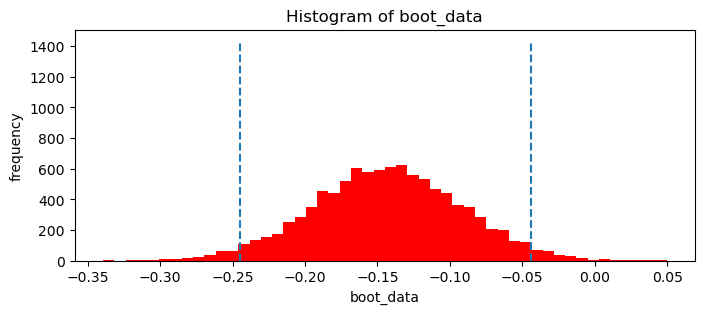

0.005037865527425217

In [169]:
N = 1000
sample_1 = np.random.normal(0.5, 1, N)
sample_2 = np.random.normal(0.5, 1, N) + 0.1

res = get_poisson_bootstrap(sample_1, sample_2, B = 10000, vis=True)
res["p_value"]